In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [69]:
df_weather = pd.read_csv("./data/Weather Obs.csv")
print(df_weather.shape)
df_weather.head()

(233738, 13)


,Municipality,Date/Time,Year,Month,Day,Max_Temp,Min_Temp,Mean_Temp,HDD,CDD,Total Rain (mm),Total Snow,Ptol
0,ALEXANDER,1/1/96,1996,1,1,-10.0,-18.0,-14.00,32.0,0.0,0.0,4.0,4.0
1,ALEXANDER,1/2/96,1996,1,2,-11.0,-21.0,-16.00,34.0,0.0,0.0,2.0,2.0
2,ALEXANDER,1/3/96,1996,1,3,-14.0,-22.0,-18.00,36.0,0.0,0.0,1.0,1.0
3,ALEXANDER,1/4/96,1996,1,4,-26.5,-36.0,-31.25,49.3,0.0,0.0,0.0,0.0
4,ALEXANDER,1/5/96,1996,1,5,-30.0,-39.0,-34.50,52.5,0.0,0.0,0.0,0.0


In [70]:
df_yields = pd.read_csv("./data/Yields.csv")
print(df_yields.shape)
df_yields.head()

(44448, 9)


,Year,Municipality,Crop,Variety,Farms,Acres,Yield/Acre,t,i
0,1996,ALEXANDER,ARGENTINE CANOLA,INNOVATOR (HCN 92) (LT),3,575.0,0.579,1,1
1,1996,ALEXANDER,ARGENTINE CANOLA,QUANTUM (91-21864 NA),6,1125.0,0.780,1,1
2,1996,ALEXANDER,ARGENTINE CANOLA,45A71 (NS1471)(ST),4,1012.0,0.756,1,1
3,1996,ALEXANDER,BARLEY,ROBUST,9,1247.0,1.607,1,1
4,1996,ALEXANDER,CANARYSEED,KEET,3,535.0,0.184,1,1


In [71]:
def build_seasonal_ols_table(
    df_weather,
    df_yields,
    shift_december=True,  # True: Dec counts toward next year's DJF (typical for seasonal analyses)
):
    w = df_weather

    # Standardize column names (easier to code)
    rename_map = {
        "Municipality": "Municipality",
        "Date/Time": "Date",
        "Year": "Year",
        "Month": "Month",
        "Day": "Day",
        "Max_Temp": "Max_Temp",
        "Min_Temp": "Min_Temp",
        "Mean_Temp": "Mean_Temp",
        "HDD": "HDD",
        "CDD": "CDD",
        "Total Rain (mm)": "Total_Rain_mm",
        "Total Snow": "Total_Snow",
        "Ptol": "Ptol",
    }
    w = w.rename(columns=rename_map)

    # Ensure numeric types where needed
    num_cols = [
        "Year","Month","Day","Max_Temp","Min_Temp","Mean_Temp",
        "HDD","CDD","Total_Rain_mm","Total_Snow","Ptol"
    ]
    for c in num_cols:
        w[c] = pd.to_numeric(w[c], errors="coerce")

    # Temperature amplitude (daily)
    w["Temp_Amp"] = w["Max_Temp"] - w["Min_Temp"]

    # Assign season by month
    # DJF = {12,1,2}, MAM = {3,4,5}, JJA = {6,7,8}, SON = {9,10,11}
    def month_to_season(m):
        if m in (12, 1, 2):
            return "DJF"
        elif m in (3, 4, 5):
            return "MAM"
        elif m in (6, 7, 8):
            return "JJA"
        else:
            return "SON"

    w["Season"] = w["Month"].apply(month_to_season)

    # Define the "effective" year for seasonal aggregation.
    # If shift_december=True, December (Month=12) is counted toward NEXT year's DJF.
    w["Eff_Year"] = w["Year"]
    if shift_december:
        w.loc[w["Month"] == 12, "Eff_Year"] = w["Year"] + 1

    # ---------- Seasonal aggregation (means over days in the season) ----------
    # Features requested per season (means):
    # - mean temperature (Mean_Temp)
    # - mean temperature amplitude (Temp_Amp)
    # - mean HDD
    # - mean CDD
    # - mean Total rain
    # - mean Total snow
    # - mean Ptol
    agg_map = {
        "Mean_Temp": "mean",
        "Temp_Amp": "mean",
        "HDD": "mean",
        "CDD": "mean",
        "Total_Rain_mm": "mean",
        "Total_Snow": "mean",
        "Ptol": "mean",
    }

    g = (
        w.groupby(["Municipality", "Eff_Year", "Season"], dropna=False)
         .agg(agg_map)
         .reset_index()
    )

    # Pivot to wide (one row per Municipality–Eff_Year; columns per Season)
    wide = g.pivot(index=["Municipality", "Eff_Year"], columns="Season")

    # Flatten MultiIndex columns to friendly names
    # e.g., Mean_Temp_DJF, Temp_Amp_MAM, ...
    wide.columns = [f"{var}_{season}" for (var, season) in wide.columns]
    wide = wide.reset_index().rename(columns={"Eff_Year": "Year"})

    # ---------- Load & tidy yields ----------
    y = df_yields
    # Keep/rename the key columns exactly as you requested
    # (We'll keep "Yield/Acre" as-is in the final table.)
    needed_y_cols = ["Year", "Municipality", "Crop", "Variety", "Yield/Acre"]

    # Ensure Year is numeric
    y["Year"] = pd.to_numeric(y["Year"], errors="coerce")

    # ---------- Merge seasonal features with yields ----------
    out = y[needed_y_cols].merge(wide, on=["Municipality", "Year"], how="left")

    # Optional: reorder columns: first the 5 requested, then the seasonal features
    base_cols = ["Year", "Municipality", "Crop", "Variety", "Yield/Acre"]
    feat_cols = [c for c in out.columns if c not in base_cols]
    out = out[base_cols + sorted(feat_cols)]

    return out

df = build_seasonal_ols_table(df_weather, df_yields, shift_december=True)
print(df.shape)
print(df.columns.tolist())
df.head()


(44448, 33)
['Year', 'Municipality', 'Crop', 'Variety', 'Yield/Acre', 'CDD_DJF', 'CDD_JJA', 'CDD_MAM', 'CDD_SON', 'HDD_DJF', 'HDD_JJA', 'HDD_MAM', 'HDD_SON', 'Mean_Temp_DJF', 'Mean_Temp_JJA', 'Mean_Temp_MAM', 'Mean_Temp_SON', 'Ptol_DJF', 'Ptol_JJA', 'Ptol_MAM', 'Ptol_SON', 'Temp_Amp_DJF', 'Temp_Amp_JJA', 'Temp_Amp_MAM', 'Temp_Amp_SON', 'Total_Rain_mm_DJF', 'Total_Rain_mm_JJA', 'Total_Rain_mm_MAM', 'Total_Rain_mm_SON', 'Total_Snow_DJF', 'Total_Snow_JJA', 'Total_Snow_MAM', 'Total_Snow_SON']


,Year,Municipality,Crop,Variety,Yield/Acre,CDD_DJF,CDD_JJA,CDD_MAM,CDD_SON,HDD_DJF,...,Temp_Amp_MAM,Temp_Amp_SON,Total_Rain_mm_DJF,Total_Rain_mm_JJA,Total_Rain_mm_MAM,Total_Rain_mm_SON,Total_Snow_DJF,Total_Snow_JJA,Total_Snow_MAM,Total_Snow_SON
0,1996,ALEXANDER,ARGENTINE CANOLA,INNOVATOR (HCN 92) (LT),0.579,0.0,1.507609,0.0,0.010989,36.901667,...,11.527174,12.016484,0.006667,2.165217,0.715217,0.740659,0.45,0.0,0.565217,0.428571
1,1996,ALEXANDER,ARGENTINE CANOLA,QUANTUM (91-21864 NA),0.780,0.0,1.507609,0.0,0.010989,36.901667,...,11.527174,12.016484,0.006667,2.165217,0.715217,0.740659,0.45,0.0,0.565217,0.428571
2,1996,ALEXANDER,ARGENTINE CANOLA,45A71 (NS1471)(ST),0.756,0.0,1.507609,0.0,0.010989,36.901667,...,11.527174,12.016484,0.006667,2.165217,0.715217,0.740659,0.45,0.0,0.565217,0.428571
3,1996,ALEXANDER,BARLEY,ROBUST,1.607,0.0,1.507609,0.0,0.010989,36.901667,...,11.527174,12.016484,0.006667,2.165217,0.715217,0.740659,0.45,0.0,0.565217,0.428571
4,1996,ALEXANDER,CANARYSEED,KEET,0.184,0.0,1.507609,0.0,0.010989,36.901667,...,11.527174,12.016484,0.006667,2.165217,0.715217,0.740659,0.45,0.0,0.565217,0.428571


In [72]:
def linear_regress(
    df,
    crop_name: str,
    variety_name: str,
    start_year: int,
    end_year: int,
    test_year_frac: float = 0.2,
):
    d = df[
        (df["Crop"] == crop_name) & 
        (df["Variety"] == variety_name) & 
        (df['Year'] >= start_year) & 
        (df['Year'] <= end_year)
        ].copy().dropna()
    
    # explanatory variables
    X = d.drop(columns=['Year','Municipality','Crop', 'Variety','Yield/Acre']) 
    # dependent variable (target)
    y = d['Yield/Acre']

    # Split the dataset into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_year_frac, random_state=42)

    ols = LinearRegression()
    ols.fit(X_train, y_train)

    # Predictions & simple metrics
    y_pred = ols.predict(X_test)
    beta0 = ols.intercept_
    beta = ols.coef_
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Intercept (β0):", beta0)
    print("Coefficients (β):")
    print(pd.Series(beta, index=X.columns))

    print("R^2:", R2)
    print("RMSE:", RMSE)

    return y_test, y_pred

y_test, y_pred = linear_regress(
    df,
    crop_name="ARGENTINE CANOLA",
    variety_name="QUANTUM (91-21864 NA)",
    start_year=1996,
    end_year=2000,
    test_year_frac=0.2,
)

Intercept (β0): -54.77757697214983
Coefficients (β):
CDD_DJF              1.837675e-12
CDD_JJA             -3.529732e+00
CDD_MAM              1.782795e+00
CDD_SON              4.295923e-01
HDD_DJF              6.240216e-01
HDD_JJA              3.659178e+00
HDD_MAM             -1.215654e+00
HDD_SON              5.224111e-02
Mean_Temp_DJF        6.029416e-01
Mean_Temp_JJA        3.614508e+00
Mean_Temp_MAM       -1.186759e+00
Mean_Temp_SON        1.922930e-02
Ptol_DJF            -8.653421e-02
Ptol_JJA             1.453785e-01
Ptol_MAM             3.168970e-02
Ptol_SON             1.849098e-02
Temp_Amp_DJF        -9.773623e-03
Temp_Amp_JJA         5.201664e-03
Temp_Amp_MAM        -6.787206e-03
Temp_Amp_SON        -1.500831e-02
Total_Rain_mm_DJF    8.137023e-02
Total_Rain_mm_JJA   -1.394869e-01
Total_Rain_mm_MAM    3.726470e-02
Total_Rain_mm_SON   -4.111114e-02
Total_Snow_DJF      -4.072371e-02
Total_Snow_JJA      -1.118330e+00
Total_Snow_MAM       5.642515e-02
Total_Snow_SON      -1.543050

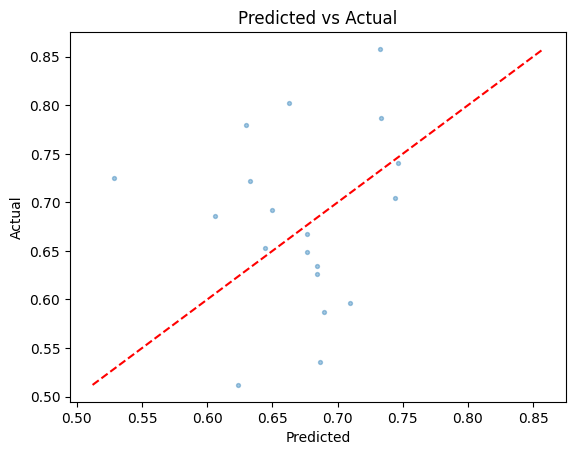

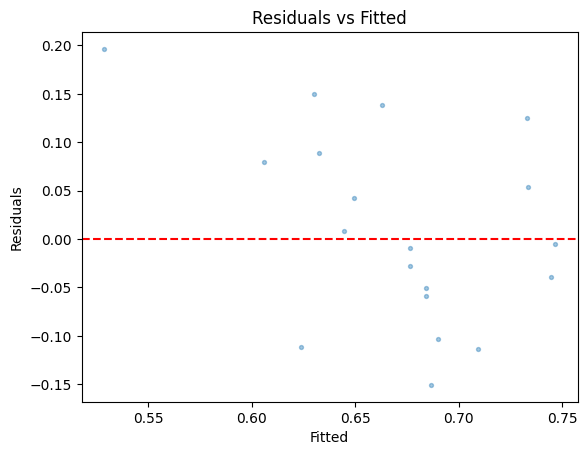

In [73]:
res = y_test - y_pred

# Predicted vs Actual
plt.scatter(y_pred, y_test, s=8, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Fitted
plt.scatter(y_pred, res, s=8, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()